# TODO

- Deterministic
    - Will probably want to use generators when paralleizing

- Need to store intersection points

- Specular reflection
    
    
- Optimization
    - Make the code faster...
    - Intersection check could be done using floating point calculation
    - What data to store
        - Need to store cound electrons reaching contacts!!!
    
    
- Ohmstats and colormap plotting
    - Ohmstats line
    - Ease, speed, and correctness
    
    
- Debugging
    - break full loop and return coords?

# Init

In [1]:
%%capture

%load_ext line_profiler

import importlib
from cycler import cycler
import numpy as np
import time

import matplotlib
import matplotlib.pyplot as plt
#%matplotlib notebook
%matplotlib inline

import sys
sys.path.insert(0, 'geo')
sys.path.insert(0, 'bandstructure')

import caustic_frame
importlib.reload(caustic_frame)

import caustic_bandstructure
importlib.reload(caustic_bandstructure)

from delafossite_bandstructure import delafossite

import monte_carlo_simulation as mcs
importlib.reload(mcs)
from shapely.geometry import LineString
from shapely.geometry import Point

import cProfile

# Set default plotting parameters

plt.rcParams['axes.prop_cycle'] = cycler(
    color=['#E24A33','#348ABD','#988ED5','#777777',
           '#FBC15E','#8EBA42','#FFB5B8'])

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = 'True'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 2.5
plt.rcParams['xtick.minor.width'] = 1

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = 'True'
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['ytick.minor.width'] = 1


plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize']=12

# Simulation

## Bar

In [2]:
k = delafossite()
bar_frame = caustic_frame.Frame('geo/bar.dxf')
bar_sim = mcs.Simulation(bar_frame, k, 0, 0.01, 100)
bar_sim.set_seed(0)

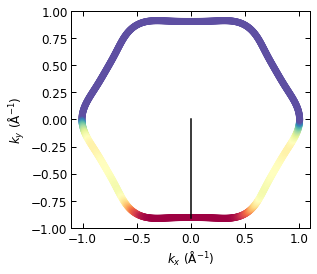

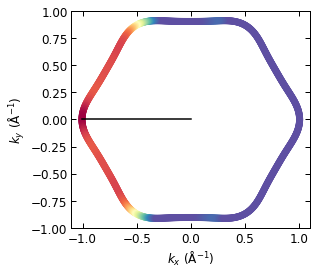

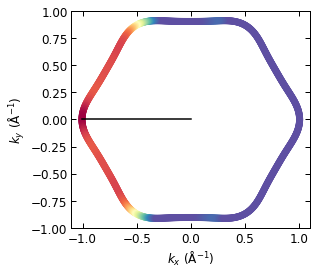

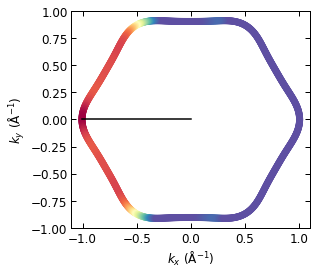

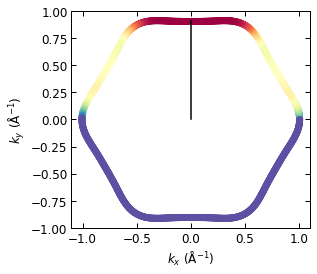

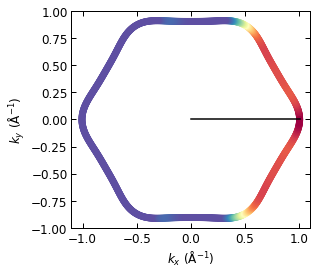

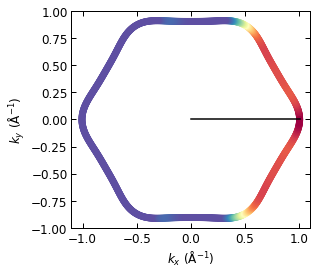

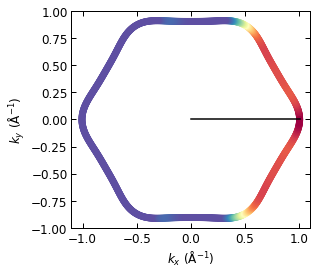

In [3]:
cmap = plt.get_cmap('Spectral_r')

for edge in bar_sim.frame.edges:
    max_p = np.max(edge.in_prob)
    colors = np.array([cmap(p/max_p) for p in edge.in_prob])
    colors = np.append(colors, [colors[0]], axis=0)
    
    fig, ax = plt.subplots()
    plt.plot((0, (np.max(bar_sim.bandstructure.k[0]*np.cos(edge.normal_angle)))*np.cos(edge.normal_angle)), (0, (np.max(bar_sim.bandstructure.k[1]*np.sin(edge.normal_angle)))*np.sin(edge.normal_angle)),'k')
    plt.scatter(bar_sim.bandstructure.k[0], bar_sim.bandstructure.k[1],c=colors)
    plt.xlabel(r'$k_x\ (\mathrm{\AA^{-1}})$')
    plt.ylabel(r'$k_y\ (\mathrm{\AA^{-1}})$')
    ax.set_aspect('equal')

In [4]:
line = LineString([(0,1),(2,3)])
(xs, ys) = line.coords.xy
dir(line)
t0 = time.time()
for i in range(3401):
    list(line.coords)
t1 = time.time()
print(t1-t0)
p1, p2 = list(line.coords)


0.029525041580200195


In [5]:
%lprun -f bar_sim.get_sorted_intersections -f bar_sim.get_intersections -f bar_sim.step_position bar_sim.run_simulation(debug=True)

/mnt/m/Users/Aaron/Dropbox (DGG Lab)/Aaron/Repositories/ballistic_montecarlo/monte_carlo_simulation.py:230: RuntimeWarning: divide by zero encountered in double_scalars
  ts = (x13*y21-x21*y13)/(x43*y21-x21*y43)
/mnt/m/Users/Aaron/Dropbox (DGG Lab)/Aaron/Repositories/ballistic_montecarlo/monte_carlo_simulation.py:231: RuntimeWarning: divide by zero encountered in double_scalars
  us = (x13*y43-x43*y13)/(x43*y21-x21*y43)


In [6]:
cProfile.runctx("bar_sim.run_simulation(debug=True)", globals(), locals(), sort='cumtime')

         425921 function calls in 1.948 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.948    1.948 {built-in method builtins.exec}
        1    0.001    0.001    1.948    1.948 <string>:1(<module>)
        1    0.010    0.010    1.947    1.947 monte_carlo_simulation.py:34(run_simulation)
     3573    0.049    0.000    1.918    0.001 monte_carlo_simulation.py:59(step_position)
     3573    0.025    0.000    1.197    0.000 monte_carlo_simulation.py:188(get_sorted_intersections)
     3573    0.148    0.000    1.143    0.000 monte_carlo_simulation.py:208(get_intersections)
     2651    0.015    0.000    0.635    0.000 base.py:647(intersection)
     2651    0.513    0.000    0.535    0.000 topology.py:63(__call__)
     3573    0.014    0.000    0.344    0.000 base.py:738(intersects)
     3573    0.294    0.000    0.327    0.000 predicates.py:11(__call__)
    28584    0.064    0.000    0.129  

In [7]:
bar_trajectories = bar_sim.run_simulation(debug=True)

geo/caustic_frame.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


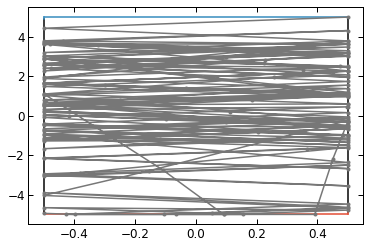

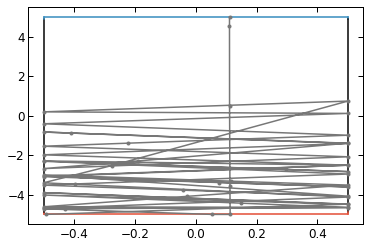

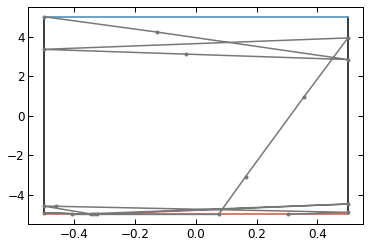

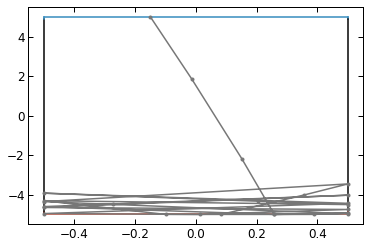

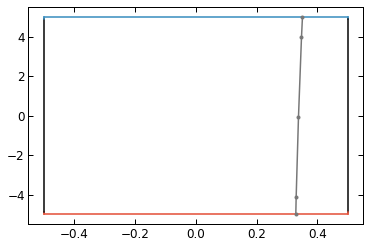

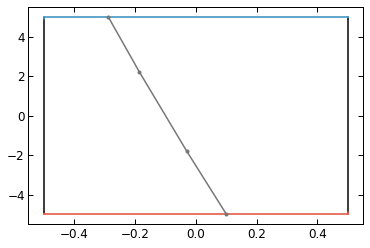

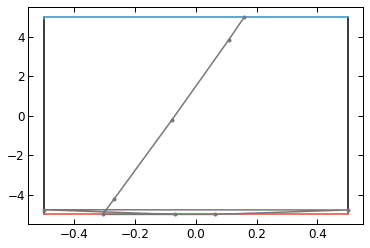

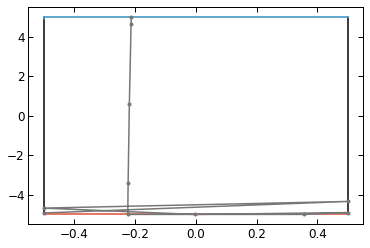

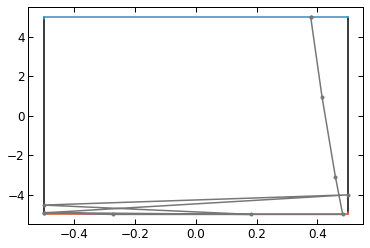

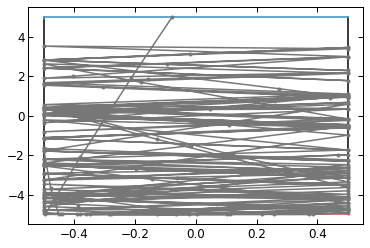

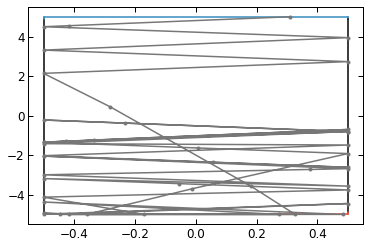

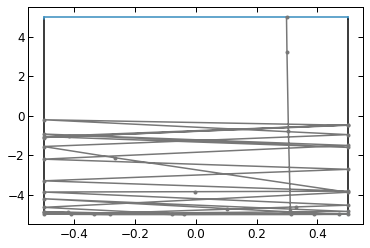

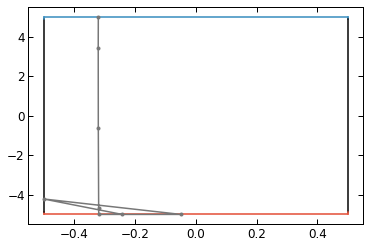

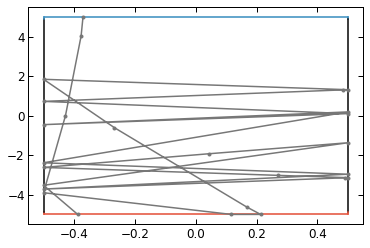

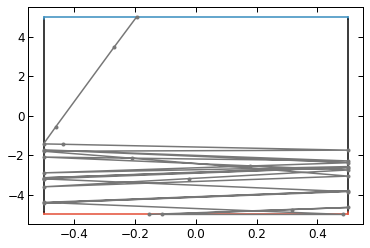

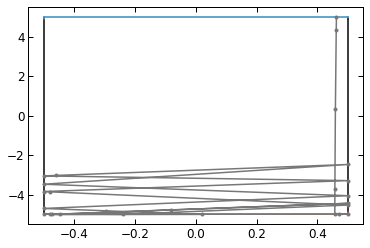

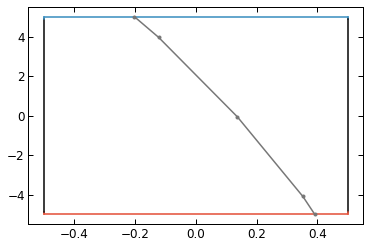

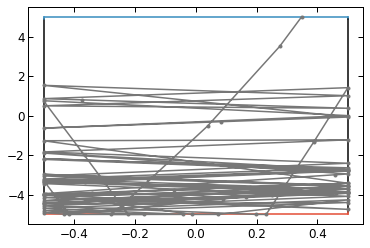

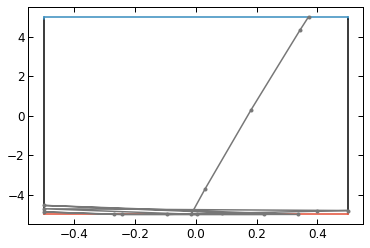

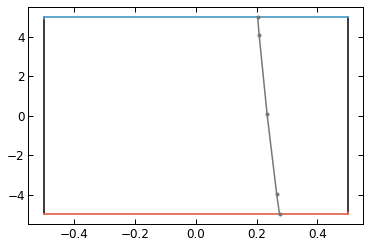

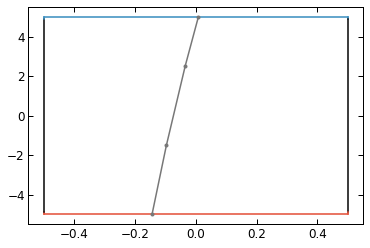

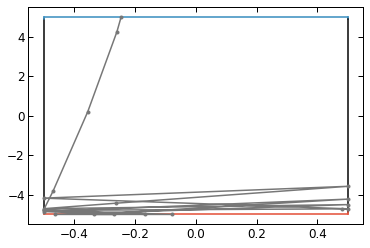

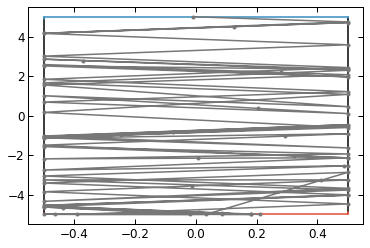

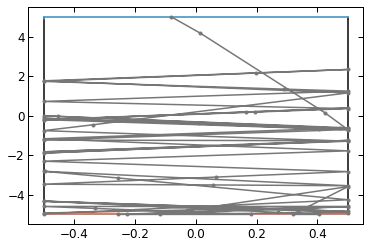

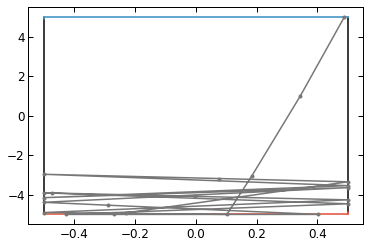

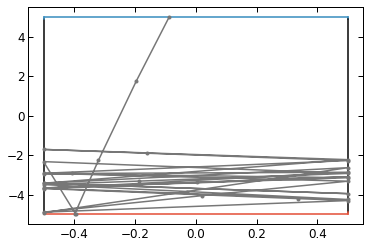

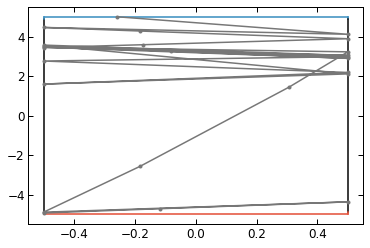

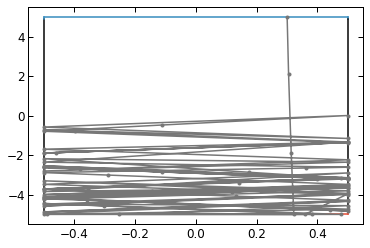

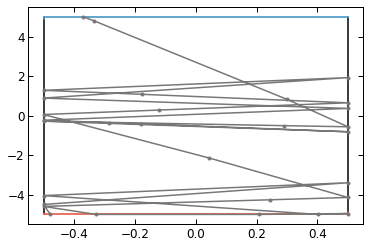

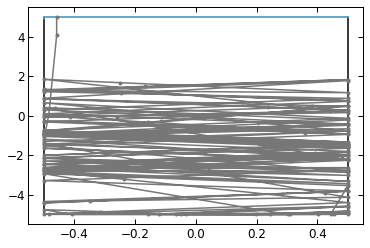

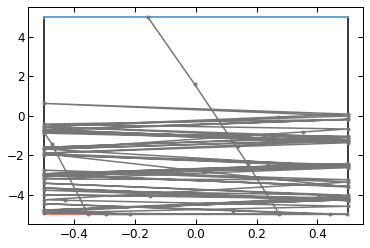

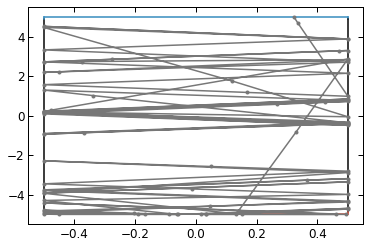

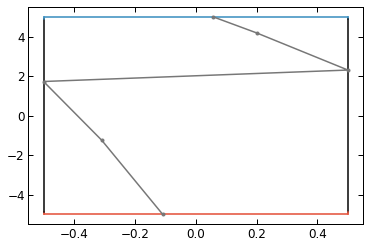

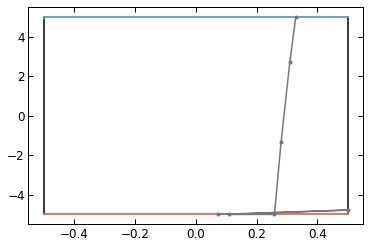

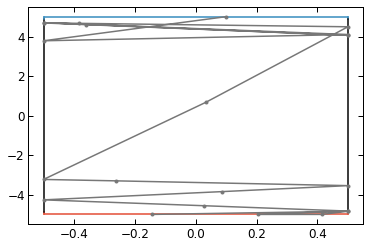

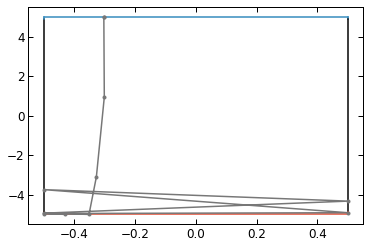

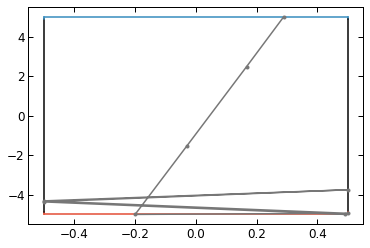

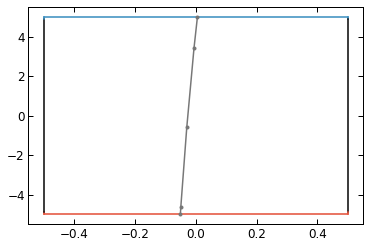

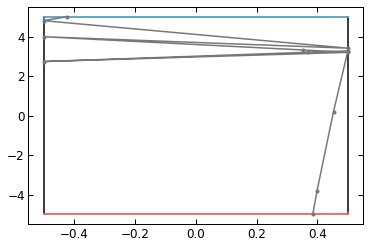

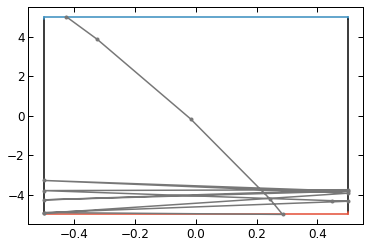

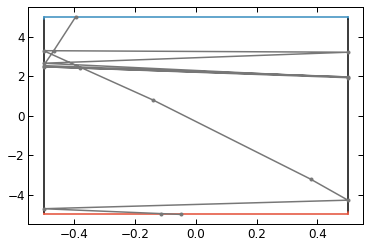

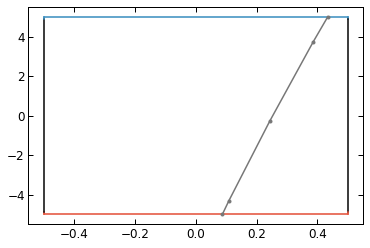

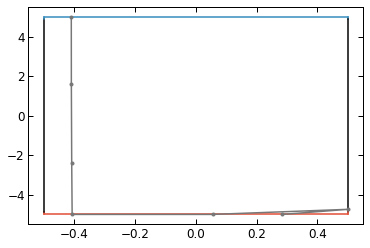

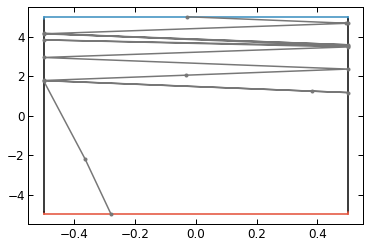

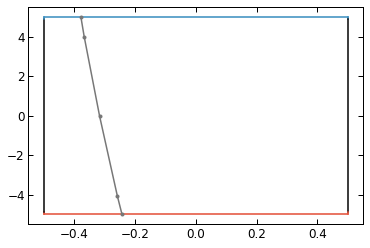

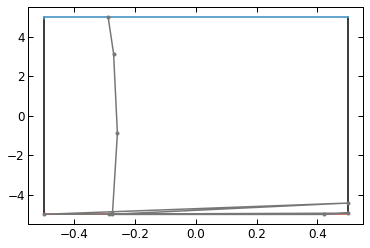

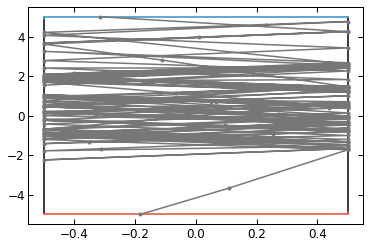

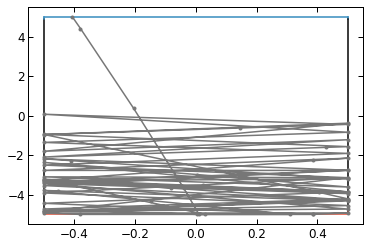

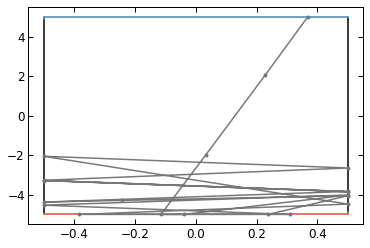

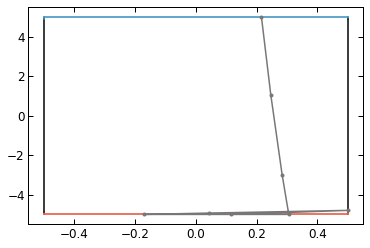

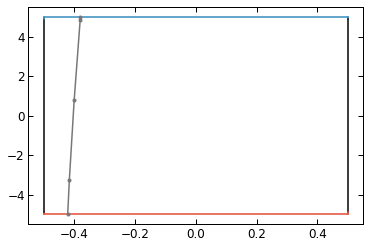

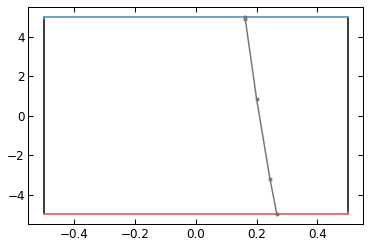

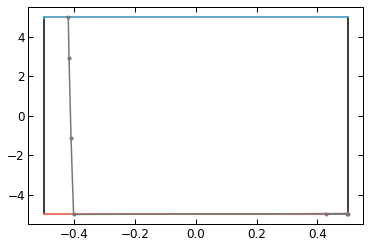

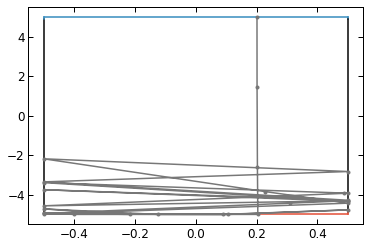

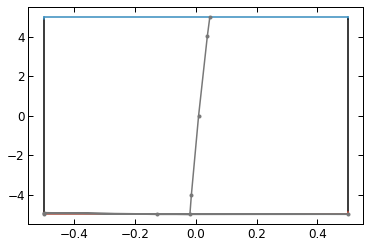

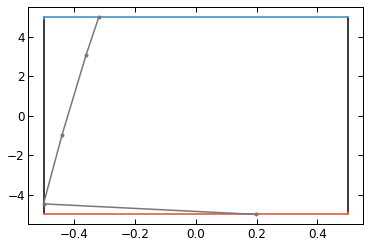

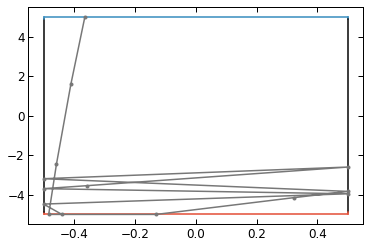

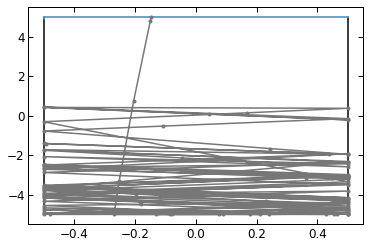

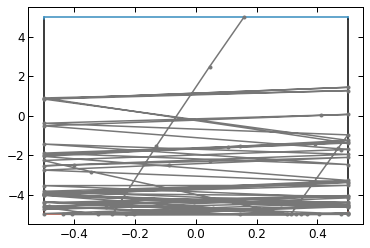

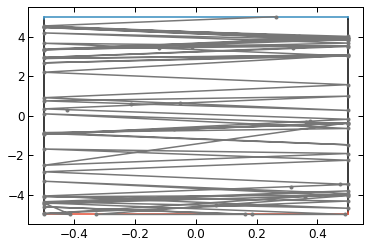

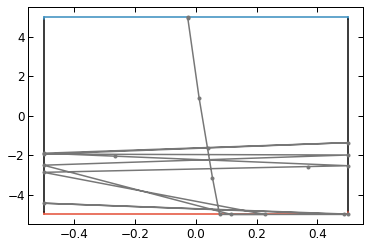

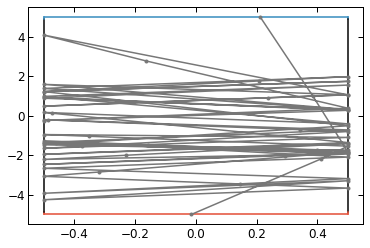

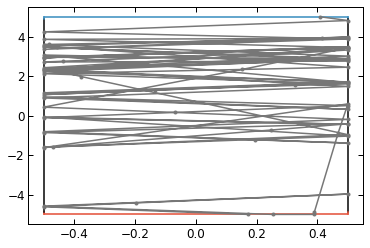

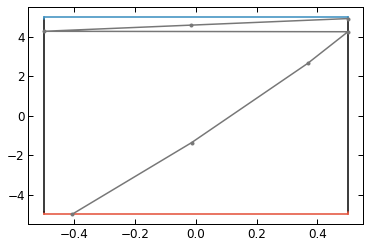

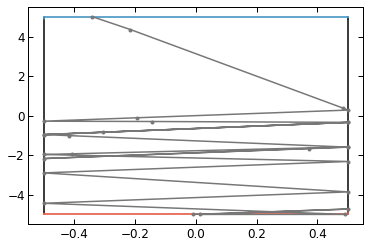

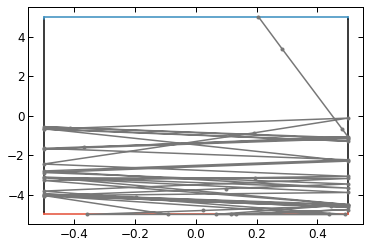

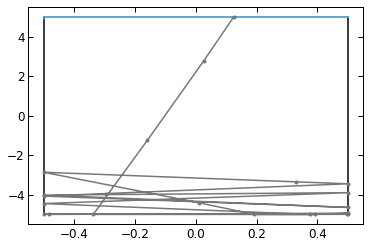

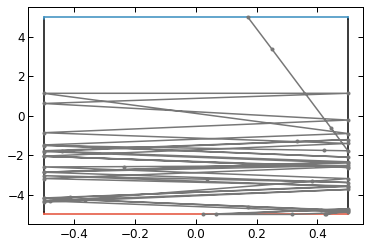

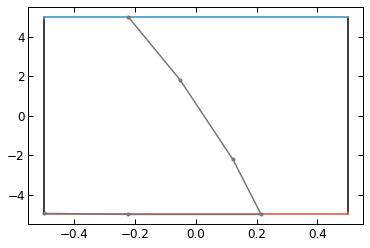

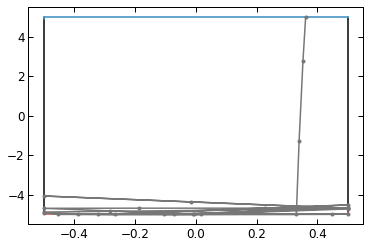

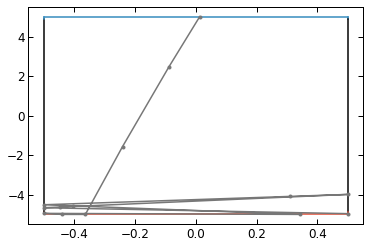

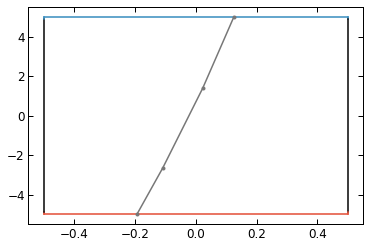

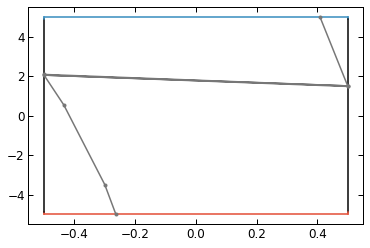

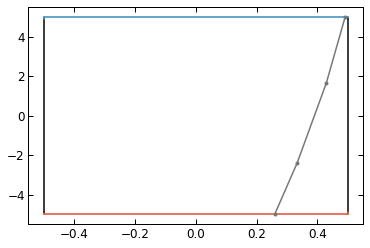

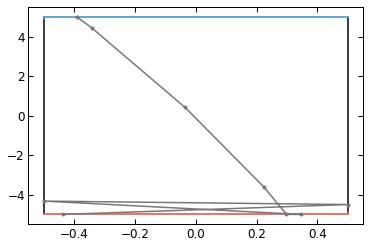

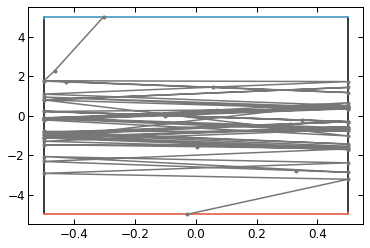

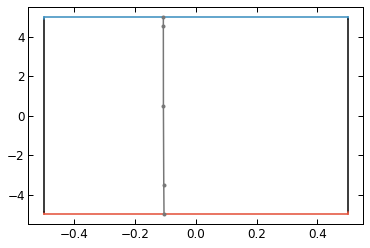

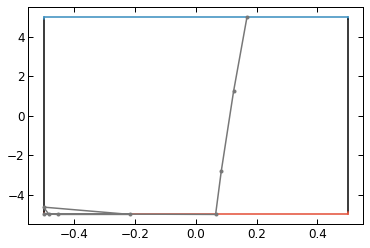

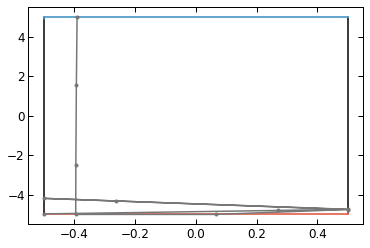

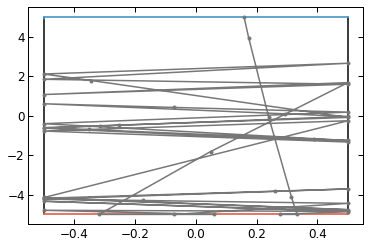

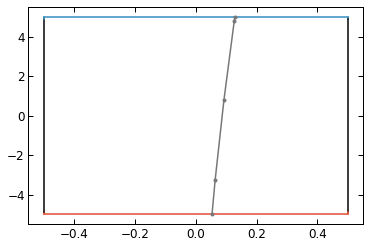

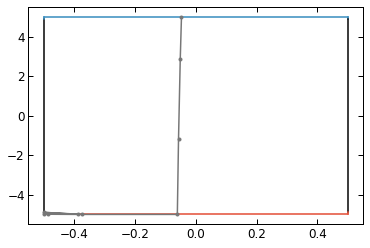

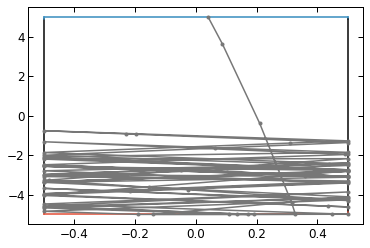

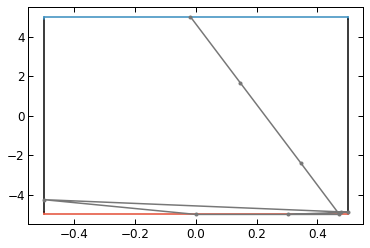

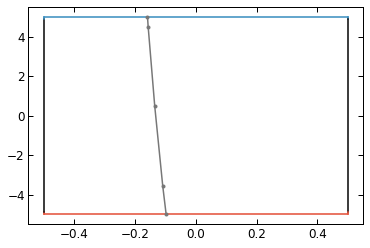

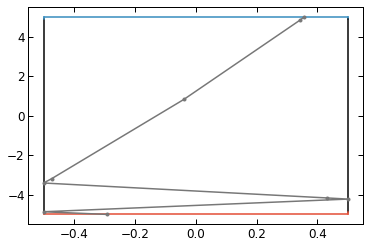

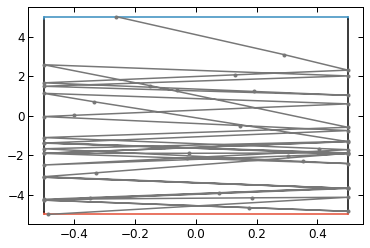

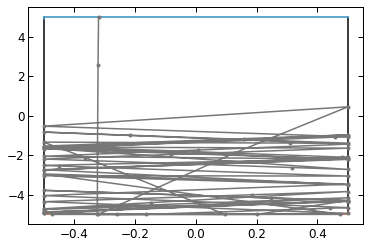

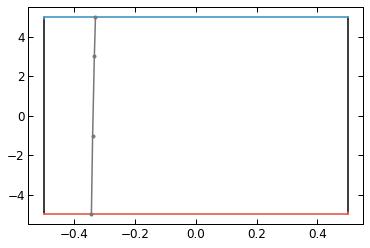

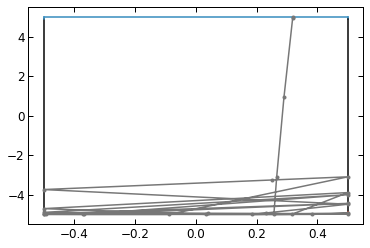

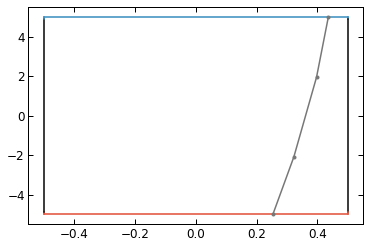

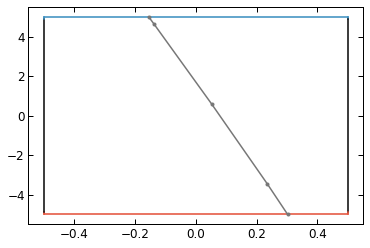

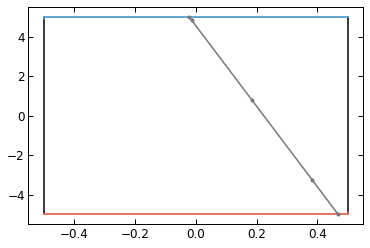

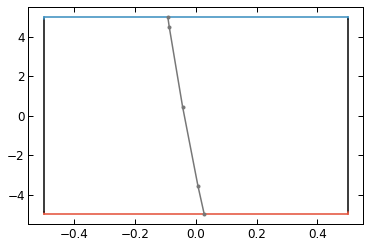

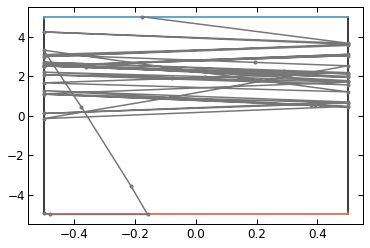

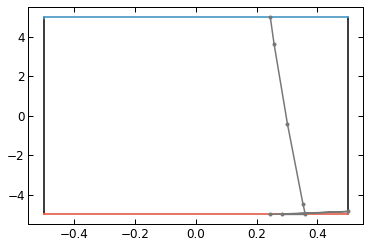

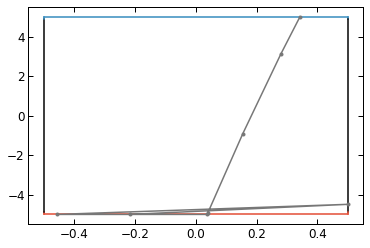

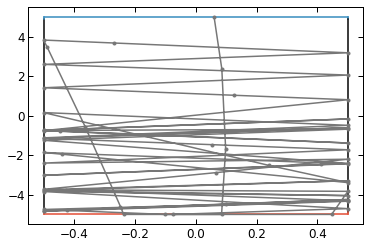

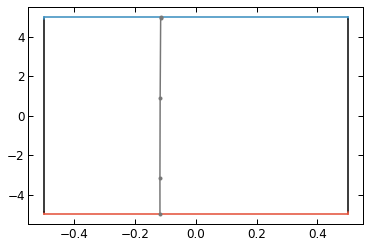

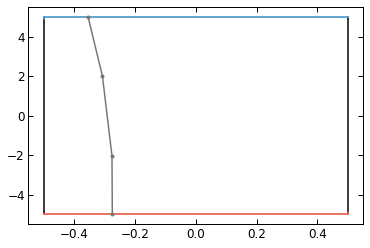

In [8]:

for trajectory in bar_trajectories:
    fig = bar_frame.gen_fig()
    ns, xs, ys = zip(*trajectory)
    plt.plot(xs,ys, 'C3.-')
    #plt.axes().set_aspect('equal')
    #plt.ylim(-5.1,-4)

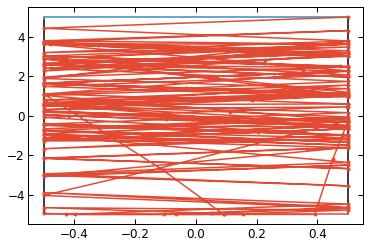

In [9]:
fig = bar_frame.gen_fig()
ns, xs, ys = zip(*bar_trajectories[0])
plt.plot(xs,ys, '.-')
#plt.ylim(-5.1,-4)

## TEF

In [11]:
k = delafossite()
frame = caustic_frame.Frame('geo/tef.dxf')
sim = mcs.Simulation(frame, k, 0, 0.01, 10)
sim.set_seed(1)

In [12]:
t0 = time.time()
trajectories = sim.run_simulation(debug=True)
t1 = time.time()
print(t1-t0)

0.7770707607269287


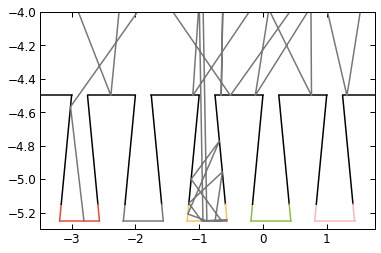

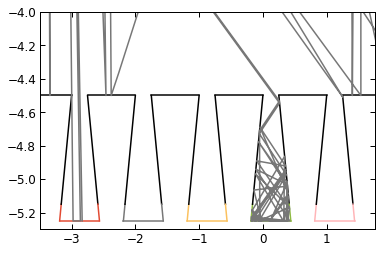

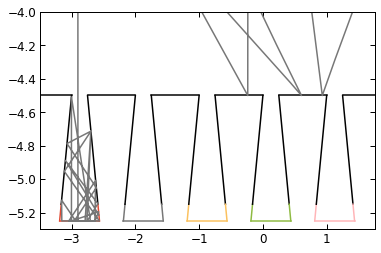

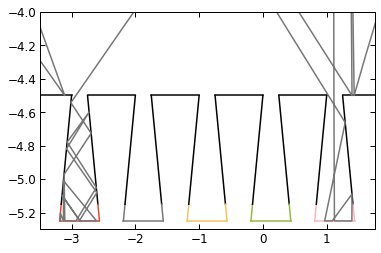

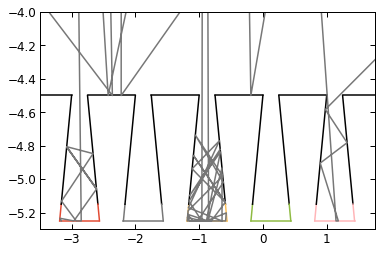

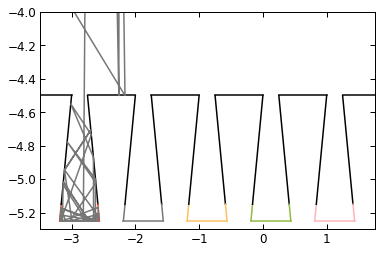

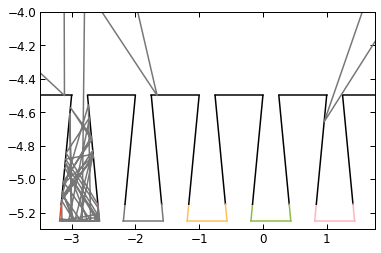

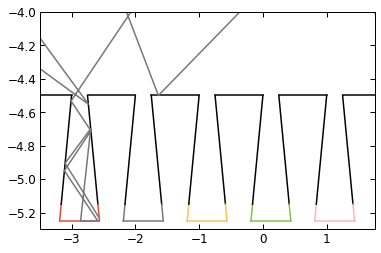

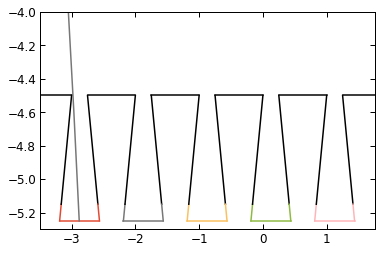

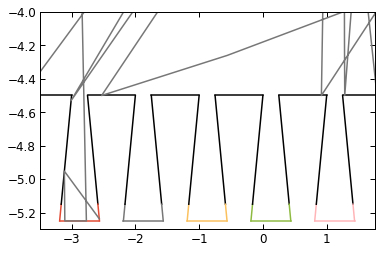

In [13]:
for trajectory in trajectories:
    fig = frame.gen_fig()
    ns, xs, ys = zip(*trajectory)
    plt.plot(xs,ys, 'C3')
    plt.xlim(-3.5, 1.75)
    plt.ylim(-5.3, -4)

(-5.3, -4.4)

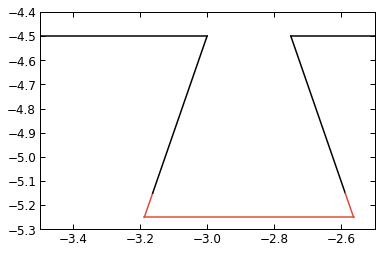

In [14]:
fig = frame.gen_fig()
ns, xs, ys = zip(*trajectories[4])
#plt.plot(xs,ys, 'C3')
plt.plot(xs[68:72],ys[68:72], 'C0')
plt.xlim(-3.5, -2.5)
plt.ylim(-5.3, -4.4)

In [15]:
sim.frame.edges

[((-10.5, 4.5), (-8.0, 4.5), 0),
 ((-8.0, 4.5), (-8.0, 9.4), 0),
 ((-8.0, 9.4), (-8.0, 9.5), 2),
 ((-8.0, 9.5), (-5.0, 9.5), 2),
 ((-5.0, 9.5), (-5.0, 9.4), 2),
 ((-5.0, 9.4), (-5.0, 4.5), 0),
 ((-5.0, 4.5), (3.0, 4.5), 0),
 ((3.0, 4.5), (3.0, 9.4), 0),
 ((3.0, 9.4), (3.0, 9.5), 3),
 ((3.0, 9.5), (6.0, 9.5), 3),
 ((6.0, 9.5), (6.0, 9.4), 3),
 ((6.0, 9.4), (6.0, 4.5), 0),
 ((6.0, 4.5), (10.5, 4.5), 0),
 ((10.5, 4.5), (10.5, -4.5), 0),
 ((10.5, -4.5), (1.25, -4.5), 0),
 ((1.25, -4.5), (1.4125, -5.15), 0),
 ((1.4125, -5.15), (1.4375, -5.25), 7),
 ((1.4375, -5.25), (0.8125, -5.25), 7),
 ((0.8125, -5.25), (0.8374999999999999, -5.15), 7),
 ((0.8374999999999999, -5.15), (1.0, -4.5), 0),
 ((1.0, -4.5), (0.25, -4.5), 0),
 ((0.25, -4.5), (0.4125000000000001, -5.15), 0),
 ((0.4125000000000001, -5.15), (0.4375, -5.25), 6),
 ((0.4375, -5.25), (-0.1875, -5.25), 6),
 ((-0.1875, -5.25), (-0.1625000000000001, -5.15), 6),
 ((-0.1625000000000001, -5.15), (0.0, -4.5), 0),
 ((0.0, -4.5), (-0.75, -4.5), 0),

In [16]:
trajectories[1][-1]
ns, xs, ys = zip(*trajectories[1])

print(ns[-5:])
print(xs[-5:])
print(ys[-5:])

ind = -2
print('')
print('inputs')
print(ns[ind], xs[ind], ys[ind])
n_up, x_up, y_up = sim.update_position(ns[ind], xs[ind], ys[ind])
print('update position')
print(n_up, x_up, y_up)


line_step = LineString([(xs[ind], ys[ind]), (x_up, y_up)])
intersections = sim.get_sorted_intersections(line_step)

vec = np.array([(x_up-xs[ind]), (y_up-ys[ind])])/np.sqrt((x_up-xs[ind])**2 +(y_up-ys[ind])**2)
print('')
print('intersection stuff')
print(intersections)
print(intersections[0])
edge, x_new, y_new, _ = intersections[0]
print(edge.layer, x_new, y_new)


print('')
print('shapely checks')
print(sim.frame.body.intersects(Point(xs[ind], ys[ind])))
print(sim.frame.body.intersects(Point(x_up, y_up)))
print(sim.frame.body.intersects(Point(x_new, y_new)))
print(sim.frame.body.intersects(Point([x_new, y_new]-1E-15*vec)))

fig = frame.gen_fig()
plt.plot(xs[-10:],ys[-10:],'.-')
plt.plot([xs[ind], x_up], [ys[ind], y_up],'.-k')
plt.xlim(-1, 1)
plt.ylim(-5.3, -4.4)


fig = frame.gen_fig()
plt.plot(xs[-3:],ys[-3:], '.-')
plt.plot(xs[-3],ys[-3], 'g.', markersize=12)
plt.plot(xs[-2],ys[-2], 'b.', markersize=12)
plt.plot(xs[-2]-1E-10*vec[0],ys[-2]-1E-10*vec[1], 'r.', markersize=12)
plt.plot([xs[ind], x_new], [ys[ind], y_new],'.-k')
plt.xlim(-1, 1)
plt.ylim(-5.3, -4.4)


print('')
print('step_position')
sim.step_position(ns[ind], xs[ind], ys[ind])

((307, 0.9110912732683777), (308, 1), (309, 1), (310, 1), (311, 1))
(-6.746601122162196, -6.982592126053939, -7.288984177888958, -7.645717065639653, -7.878821556057581)
(-4.499999999948648, -0.8326654909292892, 3.189225715694929, 7.2069573322742695, 9.499999999900513)

inputs
(310, 1) -7.645717065639653 7.2069573322742695
update position
(311, 1) -8.053651262143555 11.219795165171432


TypeError: 'LineString' object does not support indexing

In [ ]:
n_f = (173, 0.25031344146242784)
x = -2.749411058924586
y = -5.25
dr = np.array([1.46095278, 3.75949037])
[x,y] + n_f[1]*dr

In [ ]:
sim.step_position((276,1), 0.5, -5)


In [ ]:
line_step = LineString([(0.5, -5), (0.5001522540877086, -4.995969331642936)])
sim.get_intersections(line_step)

In [ ]:
x = 0.49
y = -4.9

line_step = LineString([(0.49, -4.9),(0.49, -5)])
intersections = sim.get_sorted_intersections(line_step)
list(intersections)

In [ ]:
line_step = LineString([(0.51, -4.),(0.49, -5.1)])
intersections = sim.get_sorted_intersections(line_step)
intersections

In [ ]:
freq = np.zeros(999)
n = 1000
for i in range(n):
    line_step = LineString([(0.49, -4.9),(0.5, -5)])
    intersections = sim.get_sorted_intersections(line_step)
    edge_0, x_new, y_new, _ = intersections[0]
    edge_1, _, _, _ = intersections[1]
    n_new, f_new = sim.corner_scatter(edge_0, edge_1)
    freq[n_new] += 1
    if edge_0.in_prob[n_new] <= 0 or edge_1.in_prob[n_new] <= 0:
        print(n_new)
    
prob = freq/n
fig = plt.figure()
plt.plot(edge_0.cum_prob)
plt.plot(edge_1.cum_prob)
plt.plot(np.cumsum(prob))

fig = plt.figure()
plt.plot(edge_0.in_prob)
plt.plot(edge_1.in_prob)
plt.plot(prob)

# Corner handling




- Propagating into a corner
    - exterior corner vs interior corner
        - Exterior corner:
            - What are the edge layers?
            - If scattering, take some convolved pld
        - Interior corner
            - Probably some convolution again
    - current code will return both edges being hit
    
    
    
- Convolving plds:
    - cumsum(pld_1 * pld_2)/sum(pld_1 * pld_2)?

- Injecting from corner
    - Could reject corner injection
        - This should be fine to do
        - np.random.rand chooses in [0,1)
    - Know this is an injection event and check collision with the corner
        - Requires rewriting get_intersection
    - When injecting, know you are injecting from the corner
        - Separate function corner check?
        - Choose stated from convolved probability dists

In [ ]:
r = np.random.rand()

cum_prob = sim.frame.edges[0].cum_prob

n = np.argmax(sim.frame.edges[0].cum_prob > r)
print(n, r, cum_prob[n-1], cum_prob[n])

In [ ]:
remainder = (r-cum_prob[n-1])/(cum_prob[n] - cum_prob[n-1])
print(n-1+remainder)
print(cum_prob[n] - cum_prob[n-1])
print(r - cum_prob[n-1])
ind = n-1+remainder

In [ ]:
cum_prob[-2]

In [ ]:
from geo.caustic_frame import Edge
Edge.compute_injection_index(cum_prob)

In [ ]:
np.shape(cum_prob)

In [ ]:
np.floor(ind)

In [ ]:
(1- (ind - np.floor(ind)))* sim.bandstructure.dr[:, int(np.floor(ind))]

In [ ]:
999.5 % 999

In [ ]:
x = [1, 2 ,3, 5]
cumsum = np.cumsum(x)
cumsum

In [ ]:
np.argmax(cumsum < 0.5)

Before:
n = np.argmax(cum_sum > rand)
Returns first index of cum_sum that is bigger than rand

Step was then dr[:, n]

Now want to return fractional index that corresponds to r (which is in range of (n-1, n))

this maps to (ceil(n)-n) * dr[:, ceil(n)]?
Needs correct modulo


(n, f) = 